# Market Basket Analysis

LSESU Data Science Society Project

In [1]:
#libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skewnorm 
import sqlite3

In [2]:
#import data from csv file
df_csv1 = pd.read_csv("online_retail.csv", encoding="unicode_escape") 
df_csv2 = pd.read_csv("online_retail_II.csv",  encoding="unicode_escape")
df_csv1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## Cleaning the Data

In [3]:
print(df_csv1.shape)
print(df_csv2.shape)

(541910, 8)
(525461, 8)


In [4]:
df_csv = pd.concat([df_csv1, df_csv2], axis=0)

In [5]:
df_csv.columns = df_csv.columns.str.lower().str.strip()
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [6]:
df_csv.isnull().sum() #check null values

invoice             0
stockcode           0
description      4382
quantity            0
invoicedate         0
price               0
customer id    243007
country             0
dtype: int64

In [7]:
df_csv.shape

(1067371, 8)

total rows 1067371

In [8]:
df_csv.dtypes #check columns type

invoice         object
stockcode       object
description     object
quantity         int64
invoicedate     object
price          float64
customer id    float64
country         object
dtype: object

In [9]:
df_csv["invoicedate"] = pd.to_datetime(df_csv["invoicedate"], format="%d/%m/%Y %H:%M")
df_csv.dtypes

invoice                object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
price                 float64
customer id           float64
country                object
dtype: object

In [10]:
df_csv = df_csv[df_csv["description"].notna()]
df_csv = df_csv[df_csv["quantity"] > 0]
df_csv = df_csv[df_csv["price"]> 0]
df_csv = df_csv[df_csv["country"] == "United Kingdom"]
df_csv.describe()

,quantity,price,customer id
count,958502.000000,958502.000000,725250.000000
mean,9.789489,4.021459,15559.119094
std,122.667472,51.057409,1593.844795
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,14209.000000
50%,3.000000,2.100000,15555.000000
75%,10.000000,4.150000,16938.000000
max,80995.000000,25111.090000,18287.000000


1. Exclude price below 0
2. Exclude quantity below 0 
3. Exclude NULL descriptions

In [11]:
df_csv["description"] = df_csv["description"].str.strip()
df_csv["invoice"] = df_csv["invoice"].astype("str")
df_csv["stockcode"] = df_csv["stockcode"].astype("str")
df_csv.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
len(df_csv["description"].unique())

5327

In [13]:
df_csv[df_csv["description"].str.contains("METAL LANTERN")]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
50,536373,71053,WHITE METAL LANTERN,6,2010-12-01 09:02:00,3.39,17850.0,United Kingdom
67,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
281,536396,71053,WHITE METAL LANTERN,6,2010-12-01 10:51:00,3.39,17850.0,United Kingdom
417,536406,71053,WHITE METAL LANTERN,8,2010-12-01 11:33:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
520021,537678,71053,WHITE METAL LANTERN,24,2010-12-08 09:56:00,3.39,16779.0,United Kingdom
520360,537759,71053,WHITE METAL LANTERN,4,2010-12-08 11:42:00,3.75,13126.0,United Kingdom
521182,537811,71053,WHITE METAL LANTERN,24,2010-12-08 13:30:00,3.39,17262.0,United Kingdom
523065,538010,71053,WHITE METAL LANTERN,4,2010-12-09 12:20:00,3.75,17526.0,United Kingdom


Desctiptions might not be consistent across the same product - one evidence is shown above. Hence, Asssociation Rule Analysis made based on stockcode might be more desirable.

<AxesSubplot:>

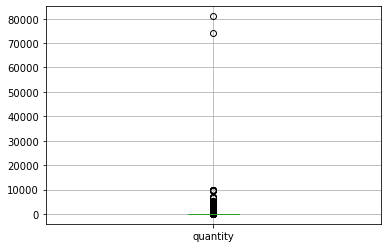

In [14]:
quantity_big = df_csv[df_csv["quantity"] > 10]
quantity_big.boxplot(column = ["quantity"])

In [15]:
bigger= quantity_big[quantity_big["quantity"] > 1000]
bigger

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
4850,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
4946,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
16435,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
16436,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
...,...,...,...,...,...,...,...,...
507883,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
507884,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
519373,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
519374,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom


In [16]:
print(quantity_big[quantity_big["invoice"]=="581458"]["description"])
print(quantity_big[quantity_big["invoice"]=="581115"]["description"])
print(len(bigger["invoice"].unique()))

540070    POPCORN HOLDER
Name: description, dtype: object
533812    METAL SIGN TAKE IT OR LEAVE IT
Name: description, dtype: object
139


I suspect a transaction with a very high product quantity might come from a B2B business. A normal customer like you and I will not probably buy a product more than _a certain number_. We can do a rigorous statistical analysis to find _this number_ and then filter out those above it. We would be left with invoice of B2C transactions.

Most B2B transactions will only have one item in their shopping cart. 

Just realised that this based on the UCI website, the customers are mostly wholesalers.

<AxesSubplot:>

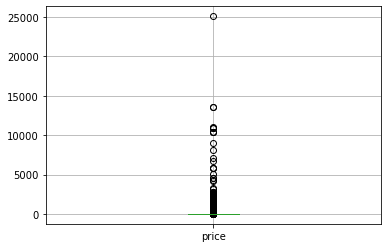

In [17]:
df_csv.boxplot(column = ["price"])

In [18]:
df_csv[df_csv["price"]>2000]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,NaN,United Kingdom
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom
297725,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
342997,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846.0,United Kingdom
374541,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
431348,573585,DOT,DOTCOM POSTAGE,1,2011-10-31 14:41:00,2019.05,NaN,United Kingdom
493021,578149,DOT,DOTCOM POSTAGE,1,2011-11-23 11:11:00,2275.54,NaN,United Kingdom


the file does include some weird transactions. some are displayed above.So not all stockcode represent products as shown above.

In [19]:
df_csv[df_csv["invoice"] == "562946"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.0,15581.0,United Kingdom


1. It's ok for the quantity of a product to be high becausse it's a B2B busineess Confirm this with teamates.
2. Need to firgure out a clever way to differentiate between actual product transactions and non product transactions. 
3. Might need to think about segmenting the customers (business and actual customer)

In [20]:
non_product = ['m','gift_0001_50','gift_0001_40','gift_0001_30','gift_0001_20','gift_0001_10',"DOT", "M", "B", "POST", "AMAZONFEE", "BANK CHARGES", 'gift_0001_80',
 'gift_0001_70','TEST002','TEST001','D','C2','ADJUST2','ADJUST',  'S']

for product in non_product:
    df_csv = df_csv[df_csv["stockcode"] !=  product]

1. m: manual
2. gift: voucher
3. POST & DOT: delivery
4. B: debt
5. D: discount
6. ADJUST: Accounting adjustments
7. C2: carriage

In [21]:
print(len(df_csv["stockcode"].unique()))
sorted(list(df_csv["stockcode"].unique()), reverse=True)

4885


['SP1002',
 'PADS',
 'DCGSSGIRL',
 'DCGSSBOY',
 'DCGS0076',
 'DCGS0075',
 'DCGS0072',
 'DCGS0070',
 'DCGS0069',
 'DCGS0068',
 'DCGS0066N',
 'DCGS0062',
 'DCGS0058',
 'DCGS0044',
 'DCGS0041',
 'DCGS0037',
 'DCGS0004',
 'DCGS0003',
 '90214Z',
 '90214Y',
 '90214W',
 '90214V',
 '90214U',
 '90214T',
 '90214S',
 '90214R',
 '90214P',
 '90214O',
 '90214N',
 '90214M',
 '90214L',
 '90214K',
 '90214J',
 '90214I',
 '90214H',
 '90214G',
 '90214F',
 '90214E',
 '90214D',
 '90214C',
 '90214B',
 '90214A',
 '90212C',
 '90212B',
 '90211B',
 '90211A',
 '90210D',
 '90210C',
 '90210B',
 '90210A',
 '90209C',
 '90209B',
 '90209A',
 '90208',
 '90206C',
 '90206A',
 '90205C',
 '90205A',
 '90204',
 '90203',
 '90202D',
 '90202C',
 '90202B',
 '90202A',
 '90201D',
 '90201C',
 '90201B',
 '90201A',
 '90200E',
 '90200D',
 '90200C',
 '90200B',
 '90200A',
 '90199D',
 '90199C',
 '90199B',
 '90199A',
 '90198B',
 '90198A',
 '90197D',
 '90197B',
 '90196B',
 '90196A',
 '90195B',
 '90195A',
 '90194',
 '90192',
 '90191',
 '9019

In [22]:
df_csv[df_csv["stockcode"] == "90211A"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
3036,536592,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2010-12-01 17:06:00,5.94,NaN,United Kingdom
13921,537434,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2010-12-06 16:57:00,5.94,NaN,United Kingdom
37060,539453,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2010-12-17 17:08:00,5.94,NaN,United Kingdom
313888,564544,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-08-25 15:50:00,5.95,15663.0,United Kingdom
436445,574149,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-11-03 11:29:00,5.95,13709.0,United Kingdom
494977,578288,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2011-11-23 14:05:00,5.95,12748.0,United Kingdom
496547,578344,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-11-24 09:21:00,5.82,NaN,United Kingdom
529477,580730,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2011-12-05 17:28:00,5.82,NaN,United Kingdom
30574,491966,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2009-12-14 17:16:00,6.07,NaN,United Kingdom
41259,492783,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2009-12-18 17:15:00,6.07,NaN,United Kingdom


<AxesSubplot:>

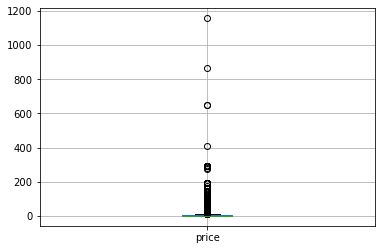

In [23]:
df_csv.boxplot(column = ["price"])

In [24]:
df_csv[df_csv["price"]>200]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.00,13145.0,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.00,16607.0,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.00,17406.0,United Kingdom
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.00,14842.0,United Kingdom
118748,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.00,13452.0,United Kingdom
134007,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.00,13452.0,United Kingdom
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.00,14973.0,United Kingdom
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.00,13015.0,United Kingdom
222671,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom


In [96]:
unique_products = df_csv.drop_duplicates(subset="stockcode", ignore_index=True)
print(len(unique_products))
unique_products.head()


4885


,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<AxesSubplot:xlabel='price', ylabel='Density'>

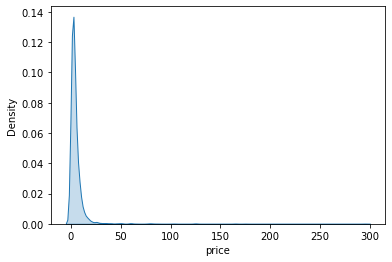

In [97]:
sns.kdeplot(unique_products["price"], shade=True)

In [98]:
unique_products.describe()

,quantity,price,customer id
count,4885.000000,4885.000000,3327.000000
mean,40.352098,4.648297,15671.436129
std,1571.860810,9.441565,1638.200682
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,14307.000000
50%,2.000000,2.550000,15723.000000
75%,6.000000,4.960000,17221.500000
max,80995.000000,295.000000,18286.000000


In [25]:
df_csv.describe()

,quantity,price,customer id
count,955994.00000,955994.000000,724458.000000
mean,9.80261,3.372446,15559.194692
std,122.80328,4.809615,1593.732321
min,1.00000,0.001000,12346.000000
25%,1.00000,1.250000,14209.000000
50%,3.00000,2.100000,15555.000000
75%,10.00000,4.130000,16938.000000
max,80995.00000,1157.150000,18287.000000


In [40]:
df_csv.to_csv("cleaned_data.csv", index=False)

In [41]:
print(df_csv["invoicedate"].max())
print(df_csv["invoicedate"].min())

2011-12-09 12:49:00
2009-12-01 07:45:00


## Using SQL to manipulate the table

In [1]:
import sqlite3

# make sure of updating the path to a file
conn = sqlite3.connect('retail3.db')

# index = False to ensure the DataFrame row index is not written into the SQL tables
df_csv.to_sql('retail3', con = conn, index = False) 

NameError: name 'df_csv' is not defined

In [26]:
import sqlite3
import pandas as pd
import seaborn as sns

db = 'retail3.db'

def run_query(q):
    # Connect to the database
    with sqlite3.connect(db) as conn:
        # Wrapper function to read_sql_query(): returns a DataFrame corresponding to the result set of 
        # the query string
        return pd.read_sql(q,conn)
 
# Function to show all the tables present in the database.
def show_tables():
    q = '''
        SELECT
            name
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

# Function to count how many rows in each table
def get_table_row_count(tablename):
    q = '''
        SELECT
            COUNT(1)
        FROM %s;
        ''' % tablename
    return run_query(q)["COUNT(1)"][0]

tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables["name"]]

tables

,name,row_count
0,retail3,955994


In [5]:
df_csv = pd.read_csv("cleaned_data.csv")
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [27]:
num_items_query = ''' 
SELECT invoice, COUNT(DISTINCT(stockcode)) "num_items", SUM(quantity) "total_quantity", SUM(quantity * price) "total_amount" 
FROM retail3
GROUP BY 1
ORDER BY 4
'''
num_items = run_query(num_items_query)
num_items 

,invoice,num_items,total_quantity,total_amount
0,528127,1,1,0.19
1,570554,1,1,0.38
2,502731,1,1,0.42
3,507293,1,1,0.42
4,518991,1,1,0.42
...,...,...,...,...
36179,533027,111,13387,49844.99
36180,576365,99,13956,50653.91
36181,574941,101,14149,52940.94
36182,541431,1,74215,77183.60


In [28]:
num_items.describe()["total_amount"]

count     36184.000000
mean        476.285134
std        1444.050310
min           0.190000
25%         148.400000
50%         300.130000
75%         471.840000
max      168469.600000
Name: total_amount, dtype: float64

In [63]:
#take bottom third quartile as potential normal customers.

potential_cust = num_items[num_items["total_amount"]<= 471.84]

the most expensive product sold by this seller has a price tag of $295. Generally most people will buy one or two items when shopping online. It's rare for a normal customer to spend a lot in one transaction. Hence, knowing that the most expensive product is sold at $295 then we can safetly bet that a normal customer is extremely unlikely to spend more than $471 in one transaction. Therfore, we infer that the top 25% of transactions in term of total_amount comes from wholesalers.

## Dealing with outliers
Remove outliers from each columns. We can say that these outliers from each column are puchases from business customers.

In [64]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_low = df_in[(df_in[col_name] < fence_low)]
    df_high = df_in[df_in[col_name] > fence_high]
    return df_out, df_low, df_high

#remove outliers in total _amount
wo_outliers, low_outliers, high_outliers = remove_outlier(potential_cust, "total_amount")
print(wo_outliers.shape)
print(low_outliers.shape)
print(high_outliers.shape)


(27140, 4)
(0, 4)
(0, 4)


          num_items  total_quantity  total_amount
count  27140.000000    27140.000000  27140.000000
mean      16.295873      130.462712    219.133739
std       15.702293      123.682606    126.442958
min        1.000000        1.000000      0.190000
25%        5.000000       48.000000    117.975000
50%       13.000000      104.000000    214.230000
75%       22.000000      181.000000    317.620000
max      175.000000     3186.000000    471.840000


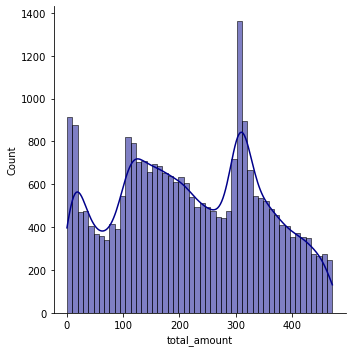

In [65]:
sns.displot(wo_outliers["total_amount"], kind="hist", kde=True, bins=50, color = 'darkblue')
print(wo_outliers.describe())

<AxesSubplot:xlabel='total_amount', ylabel='Density'>

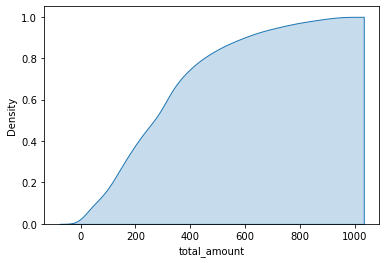

In [31]:
sns.kdeplot(wo_outliers["total_amount"], shade=True, cumulative=True)

<AxesSubplot:xlabel='total_amount', ylabel='Density'>

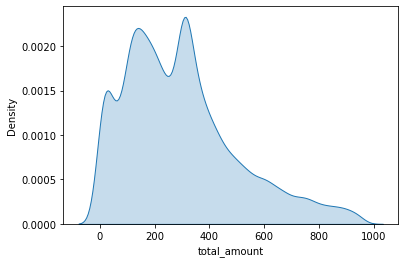

In [32]:
sns.kdeplot(wo_outliers["total_amount"], shade=True)

Majority of the customers are purchasing items with a total amount ranging from $100 to $400

In [33]:
first = wo_outliers["total_amount"].quantile(0.25)
wo_outliers[wo_outliers["total_amount"]<first]

,invoice,num_items,total_quantity,total_amount
0,528127,1,1,0.19
1,570554,1,1,0.38
2,502731,1,1,0.42
3,507293,1,1,0.42
4,518991,1,1,0.42
...,...,...,...,...
8261,565087,7,20,137.38
8262,490293,14,130,137.40
8263,516260,3,52,137.40
8264,523145,4,76,137.40


In [66]:
#remove outliers in num_items column. removing purchases with extremly high number of different products purchased.
wo_outliers2, low_outliers2, high_outliers2  = remove_outlier(wo_outliers, "num_items")
print(wo_outliers2.shape)
print(low_outliers2.shape)
print(high_outliers2.shape)

(25729, 4)
(0, 4)
(1411, 4)


In [67]:
wo_outliers2.describe()

,num_items,total_quantity,total_amount
count,25729.00000,25729.000000,25729.000000
mean,13.70609,126.695635,213.561955
std,10.85585,123.908526,125.816692
min,1.00000,1.000000,0.190000
25%,5.00000,45.000000,114.060000
50%,12.00000,99.000000,205.480000
75%,20.00000,176.000000,313.400000
max,47.00000,3186.000000,471.840000


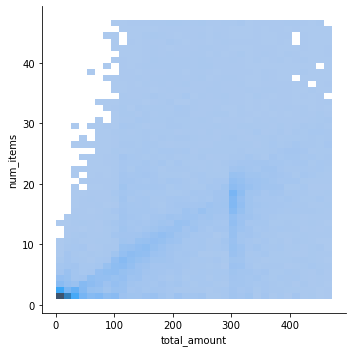

In [68]:
sns.displot(x="total_amount", y="num_items", data=wo_outliers2)

Overlapped data points between total-amount and num_items are concentrated in the darker region.

<AxesSubplot:xlabel='num_items', ylabel='Density'>

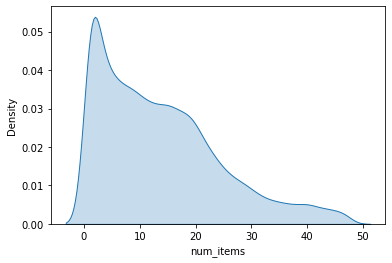

In [69]:
sns.kdeplot(wo_outliers2["num_items"], shade=True)

<AxesSubplot:xlabel='total_amount', ylabel='Density'>

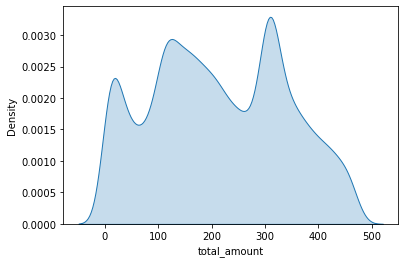

In [70]:
sns.kdeplot(wo_outliers2["total_amount"], shade=True)

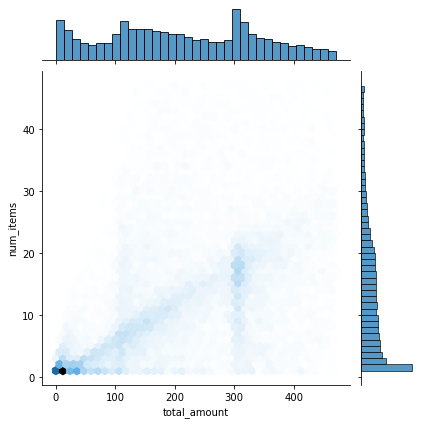

In [71]:
sns.jointplot(x="total_amount", y="num_items",kind="hex", data=wo_outliers2)

In [72]:
#remove outliers in total_quantity column. removing purchases with extremly high quantity of products purchased.
wo_outliers3, low_outliers3, high_outliers3  = remove_outlier(wo_outliers2, "total_quantity")
print(wo_outliers3.shape)
print(low_outliers3.shape)
print(high_outliers3.shape)

(24857, 4)
(0, 4)
(872, 4)


In [41]:
wo_outliers3.describe()

,num_items,total_quantity,total_amount
count,29957.000000,29957.000000,29957.000000
mean,15.718196,142.233368,268.565434
std,12.646718,112.392305,186.644034
min,1.000000,1.000000,0.190000
25%,5.000000,53.000000,127.200000
50%,13.000000,116.000000,242.910000
75%,23.000000,208.000000,364.320000
max,55.000000,483.000000,955.900000


Removing outliers for each columns so that clustering can work better. 

We may agree that an extremly high value for each column indicates that the purchase is made by a wholesler rather than a normal customer. 

## Clustering

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(wo_outliers3.drop('invoice',axis=1)) 
scaled = pd.DataFrame(scaled,columns = ['num_items','total_quantity', 'total_amount'])

In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
scores = []
silhouette = {}
for i in range(2,10):
    kmeans = KMeans(n_clusters = i, max_iter = 40).fit(scaled)
    cluster_labels = kmeans.labels_
    silhouette[i] = silhouette_score(scaled,cluster_labels)
    scores.append(kmeans.inertia_)

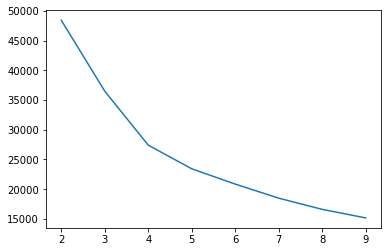

In [90]:
plt.plot(range(2,10,1), scores)

In [91]:
silhouette

{2: 0.4115859697684771,
 3: 0.35044454995704505,
 4: 0.3871697023241605,
 5: 0.32829981596319363,
 6: 0.33208188954657697,
 7: 0.3477070151045758,
 8: 0.3397335202250566,
 9: 0.3145204012046771}

In [75]:
# Final Model
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2).fit(scaled)
cluster_labels = kmeans.labels_
wo_outliers3['Cluster'] = cluster_labels

C:\Users\HAZRUL~1\AppData\Local\Temp/ipykernel_14108/1283823300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_outliers3['Cluster'] = cluster_labels


In [76]:
wo_outliers3.head()

,invoice,num_items,total_quantity,total_amount,Cluster
0,528127,1,1,0.19,0
1,570554,1,1,0.38,0
2,502731,1,1,0.42,0
3,507293,1,1,0.42,0
4,518991,1,1,0.42,0


In [77]:
cluster1 = wo_outliers3[wo_outliers3['Cluster']==0] 
cluster1

,invoice,num_items,total_quantity,total_amount,Cluster
0,528127,1,1,0.19,0
1,570554,1,1,0.38,0
2,502731,1,1,0.42,0
3,507293,1,1,0.42,0
4,518991,1,1,0.42,0
...,...,...,...,...,...
25523,508739,1,12,419.40,0
25524,542145,1,12,419.40,0
25536,532047,1,6,419.70,0
26250,541426,1,4,440.00,0


In [78]:
cluster2 =wo_outliers3[wo_outliers3['Cluster']==1] 
cluster2

,invoice,num_items,total_quantity,total_amount,Cluster
4056,574470,25,250,71.70,1
4139,562421,9,264,74.40,1
4174,564164,1,300,75.00,1
4207,508071,7,288,75.72,1
4488,561624,5,352,81.60,1
...,...,...,...,...,...
27133,554142,12,136,471.60,1
27134,575978,6,138,471.60,1
27137,532340,29,362,471.84,1
27138,566705,15,162,471.84,1


<AxesSubplot:xlabel='total_amount', ylabel='Density'>

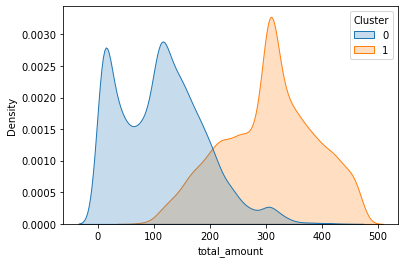

In [79]:
sns.kdeplot(x="total_amount", shade=True, hue="Cluster", data=wo_outliers3)

<AxesSubplot:xlabel='total_quantity', ylabel='Density'>

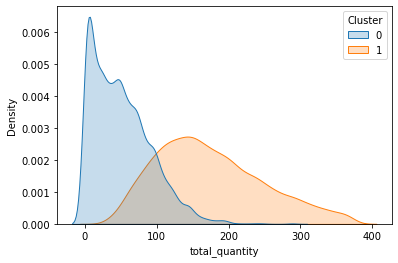

In [80]:
sns.kdeplot(x="total_quantity", shade=True, hue="Cluster", data=wo_outliers3)

<AxesSubplot:xlabel='num_items', ylabel='Density'>

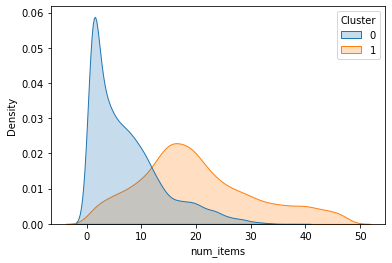

In [81]:
sns.kdeplot(x="num_items", shade=True, hue="Cluster", data=wo_outliers3)

Cluster 0 can be viewed as small customers deduced from the distibutions above while cluster 1 can be view as wholeselers. 

The reasons being:
1. Cluster 0 is positive skewed for all three distributions. Due to this fact, the mean of this cluster is less than its counterpart for all distributions
2. Cluster 1 distributions almost fit a normal distribution for all three features and have higher mean. 

Hence, we can conlcude that for each transaction, the majority of cluster 0 prefer to purchase fewer number of different products, fewer quantity and spend less in one basket. The opposite is true for cluster 1.

The joint plots below showcase better insights and reinforce the arguments of the proposition that cluster 0 is a small customers while cluster 1 is a wholeseler. 

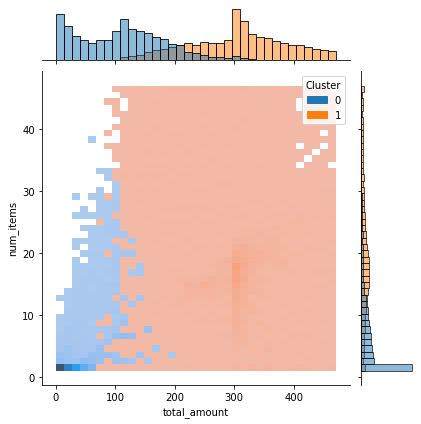

In [82]:
sns.jointplot(x="total_amount", y="num_items", kind="hist", hue="Cluster", data=wo_outliers3)

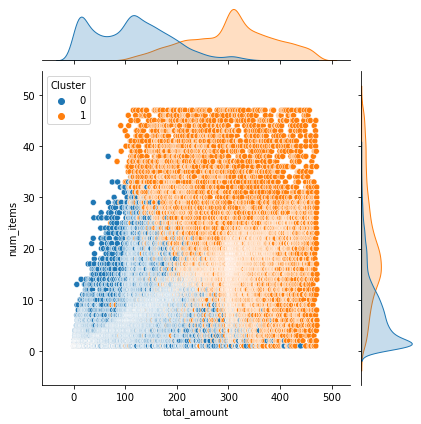

In [83]:
sns.jointplot(x="total_amount", y="num_items", kind="scatter", hue="Cluster", data=wo_outliers3)

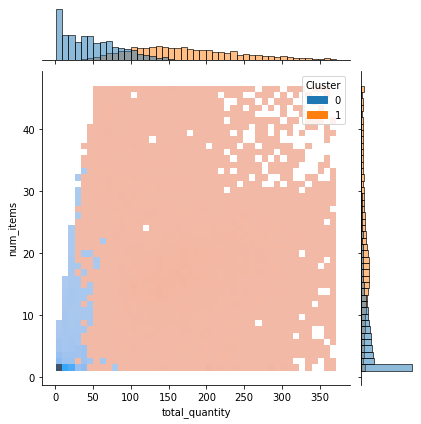

In [84]:
sns.jointplot(x="total_quantity", y="num_items", kind="hist", hue="Cluster", data=wo_outliers3)

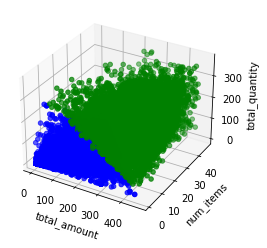

In [85]:
#import the libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Generate the values
x_vals = wo_outliers3["total_amount"]
y_vals = wo_outliers3["num_items"]
z_vals = wo_outliers3["total_quantity"]

# Plot the values
colormap =np.array(["b", "g"])

ax.scatter(x_vals, y_vals, z_vals, c=colormap[wo_outliers3["Cluster"]], marker='o')
ax.set_xlabel('total_amount')
ax.set_ylabel('num_items')
ax.set_zlabel('total_quantity')
plt.show()

In [87]:
len(wo_outliers3[wo_outliers3["Cluster"]==0])/len(num_items)

0.34553946495688703

Percentage of transactions from normal customers. 

In [89]:
normal_cust = wo_outliers3[wo_outliers3["Cluster"]==0]

n_c_invoices = normal_cust["invoice"]
len(n_c_invoices)

12503

In [108]:
normal_df = df_csv[df_csv["invoice"].isin(n_c_invoices) == True]
normal_df.reset_index(drop=True, inplace=True)
print(len(normal_df))
print(len(normal_df)/len(df_csv))
normal_df.head()

93027
0.09730918813297991


,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [107]:
business_df = df_csv[df_csv["invoice"].isin(n_c_invoices) == False]
business_df.reset_index(drop=True, inplace=True)
print(len(business_df))
print(len(business_df)/len(df_csv))
business_df.head()

862967
0.90269081186702


,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
1,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom
2,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom
3,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047.0,United Kingdom
4,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047.0,United Kingdom


In [109]:
normal_df.to_csv("normal_customers.csv", index=False)
business_df.to_csv("business_customers.csv", index=False)

In [121]:
print(sns.__version__)

0.11.0


In [122]:
conn.close()